<a href="https://colab.research.google.com/github/AzlinRusnan/Machine-Learning/blob/main/Linear_Model_Selection_and_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This topic shows methos used to improve the accuracy and interpretability of linear models, especially when dealing with complex data or when the number of predictors (variables) is high compared to the number of observations (data points).

LMS involves choosing the best subset of predictors that contribute meaningfully to predicting the output.


*   The goal is to select model that neither overfit nor underfits the data
*   Overfitting happens when a model is too complex, capturing noise in the data rather than the actual underlying pattern.
*   Underfitting occurs when a model is too simple to capture the underlying pattern in the data.

**Common technique of LMS**


1.   Stepwise Regression


*   Forward Selection - Starting with no variable and adding them one by one based on statistical criteria
*   Backward Selection - Starting with all variables and removing them one at a time.

*   Both
   

2.   Best Subset Selection


*   This methods evaluates all possible combinations of variables to find the subset that best fit the data according to a chosen criterion.










In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
file_path = '/content/gdrive/MyDrive/STQD 6024 Machine Learning/hitters.csv'
hitters_df = pd.read_csv(file_path)
hitters_df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,#NAME?,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,#NAME?,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,#NAME?,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,#NAME?,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,#NAME?,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


First of all, we note that the Salary variable is missing for some of the players. The isnull() function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a TRUE value for any elements that are missing, and a FALSE value for non-missing elements. The sum() function can then be used to count all of the missing elements

In [5]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())

Number of null values: 59


In [6]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

Dimensions of original data: (322, 21)


In [8]:
# Drop any rows the contain missing values, along with the player names
hitters_df_clean = hitters_df.dropna().drop('Unnamed: 0', axis=1)
print(hitters_df_clean)

     AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  \
1      315    81      7    24   38     39     14    3449    835      69   
2      479   130     18    66   72     76      3    1624    457      63   
3      496   141     20    65   78     37     11    5628   1575     225   
4      321    87     10    39   42     30      2     396    101      12   
5      594   169      4    74   51     35     11    4408   1133      19   
..     ...   ...    ...   ...  ...    ...    ...     ...    ...     ...   
317    497   127      7    65   48     37      5    2703    806      32   
318    492   136      5    76   50     94     12    5511   1511      39   
319    475   126      3    61   43     52      6    1700    433       7   
320    573   144      9    85   60     78      8    3198    857      97   
321    631   170      9    77   44     31     11    4908   1457      30   

     CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary  \
1      321   414     

In [9]:
 #Print the dimensions of the modified Hitters data (263 rows x 20 columns)
 print("Dimensions of modified data:", hitters_df_clean.shape)

Dimensions of modified data: (263, 20)


In [10]:
# One last check: should return 0
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

Number of null values: 0


In [17]:
dummies = pd.get_dummies(hitters_df_clean[['League','Division','NewLeague']])
y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

We can perform best subset selection by identifying the best model that contains a given number of predictors, where best is quantified using RSS. We'll define a helper function to outputs the best set of variables for each model size:

In [21]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)].astype('float'))
    regr = model.fit()
    return {"model":regr, "RSS":((regr.predict(X[list(feature_set)]) - y) ** 2).sum()}

In [19]:
def getBest(k):

    tic = time.time()

    results = []

    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]

    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")

    # Return the best model, along with some other useful information about the model
    return best_model

This returns a DataFrame containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors  𝑘
 :

In [22]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 19 models on 1 predictors in 0.08019685745239258 seconds.
Processed 171 models on 2 predictors in 0.4088740348815918 seconds.
Processed 969 models on 3 predictors in 2.620697498321533 seconds.
Processed 3876 models on 4 predictors in 11.460448980331421 seconds.
Processed 11628 models on 5 predictors in 36.66340756416321 seconds.
Processed 27132 models on 6 predictors in 88.38613629341125 seconds.
Processed 50388 models on 7 predictors in 164.63382244110107 seconds.
Total elapsed time: 305.2003548145294 seconds.


Processed Models on Predictors: For example, "Processed 19 models on 1 predictors in 0.105962 seconds" means that 19 models each containing 1 predictor were fitted, and it took about 0.106 seconds to compute all these models.

Now we have one big DataFrame that contains the best models we've generated along with their RSS:

In [23]:
models_best

,RSS,model
1,43213925.909868,<statsmodels.regression.linear_model.Regressio...
2,30733054.433644,<statsmodels.regression.linear_model.Regressio...
3,29410713.176731,<statsmodels.regression.linear_model.Regressio...
4,27976782.522603,<statsmodels.regression.linear_model.Regressio...
5,27187795.009508,<statsmodels.regression.linear_model.Regressio...
6,26397720.512772,<statsmodels.regression.linear_model.Regressio...
7,26064130.610341,<statsmodels.regression.linear_model.Regressio...


Best Model Information

This set of results provides details on the performance of the best model selected for each number of predictors:

RSS (Residual Sum of Squares): This metric measures the amount of variance that is not explained by the model. A lower RSS indicates a model that better fits the data.

Model Object: This indicates the specific model that was chosen as the best for each number of predictors. It's represented as a model object from the statsmodels library, which contains all the statistical details about the model.

Rows Indexed by Number of Predictors: Each row represents the best model using a specific number of predictors. For example, the row indexed by 1 shows the best model using 1 predictor, with its RSS and the model object itself.

If we want to access the details of each model, no problem! We can get a full rundown of a single model using the summary() function:

In [24]:
print(models_best.loc[7,"model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.792
Method:                 Least Squares   F-statistic:                              144.2
Date:                Wed, 08 May 2024   Prob (F-statistic):                    4.76e-85
Time:                        02:10:45   Log-Likelihood:                         -1885.9
No. Observations:                 263   AIC:                                      3786.
Df Residuals:                     256   BIC:                                      3811.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

OLS regression model you are examining, the null hypothesis typically represents a "no effect" or "zero effect" assumption. For each predictor in the model, the null hypothesis states that the predictor's coefficient is zero, meaning that the predictor has no impact on the dependent variable

**Null Hypothesis (H0)** for Hits: The coefficient of Hits is zero, which means that Hits has no effect on Salary.

**Alternative Hypothesis (H1)** for Hits: The coefficient of Hits is not zero, implying that Hits does have an effect on Salary.

P>|t| = 0.001 for Hits: This p-value is very low and typically much less than any common significance level (e.g., 0.05 or 0.01). Therefore, you reject the null hypothesis that the coefficient for Hits is zero. There is strong evidence to suggest that Hits has a significant positive effect on Salary

In summary, all these statistical outputs indicate that Hits is a significant predictor of Salary. The coefficient of 1.6800 suggests a positive relationship: as Hits increases, so does Salary, at least within the context of the data and model used.

In [26]:
print(getBest(17)["model"].summary())

Processed 171 models on 17 predictors in 0.6735725402832031 seconds.
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              61.54
Date:                Wed, 08 May 2024   Prob (F-statistic):                    2.25e-78
Time:                        02:39:37   Log-Likelihood:                         -1878.0
No. Observations:                 263   AIC:                                      3790.
Df Residuals:                     246   BIC:                                      3851.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>

Rather than letting the results of our call to the summary() function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the  𝑅2
  value:

In [27]:
models_best.loc[2, "model"].rsquared

0.7614950002332872

In [28]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

As you can see from the values, the R-squared value generally increases as more predictors are added to the model. This suggests that models with more predictors are explaining a higher proportion of the variance in the dependent variable:

For 1 predictor: The model explains about 66.46% of the variance.

For 2 predictors: The explanation increases to about 76.15%.

For 3 predictors and beyond, the explanation keeps improving, reaching up to about 79.77% with 7 predictors.

This output is useful for assessing the effectiveness of the models. Higher R-squared values generally suggest a model that better fits the data. However, it's also important to consider the potential for overfitting when adding more predictors, as well as other metrics like Adjusted R-squared, which adjusts the statistic based on the number of predictors and the complexity of the model.


---



Plotting RSS, adjusted  𝑅2
 , AIC, and BIC for all of the models at once will help us decide which model to select. Note the type="l" option tells R to connect the plotted points with lines:

Text(0, 0.5, 'BIC')

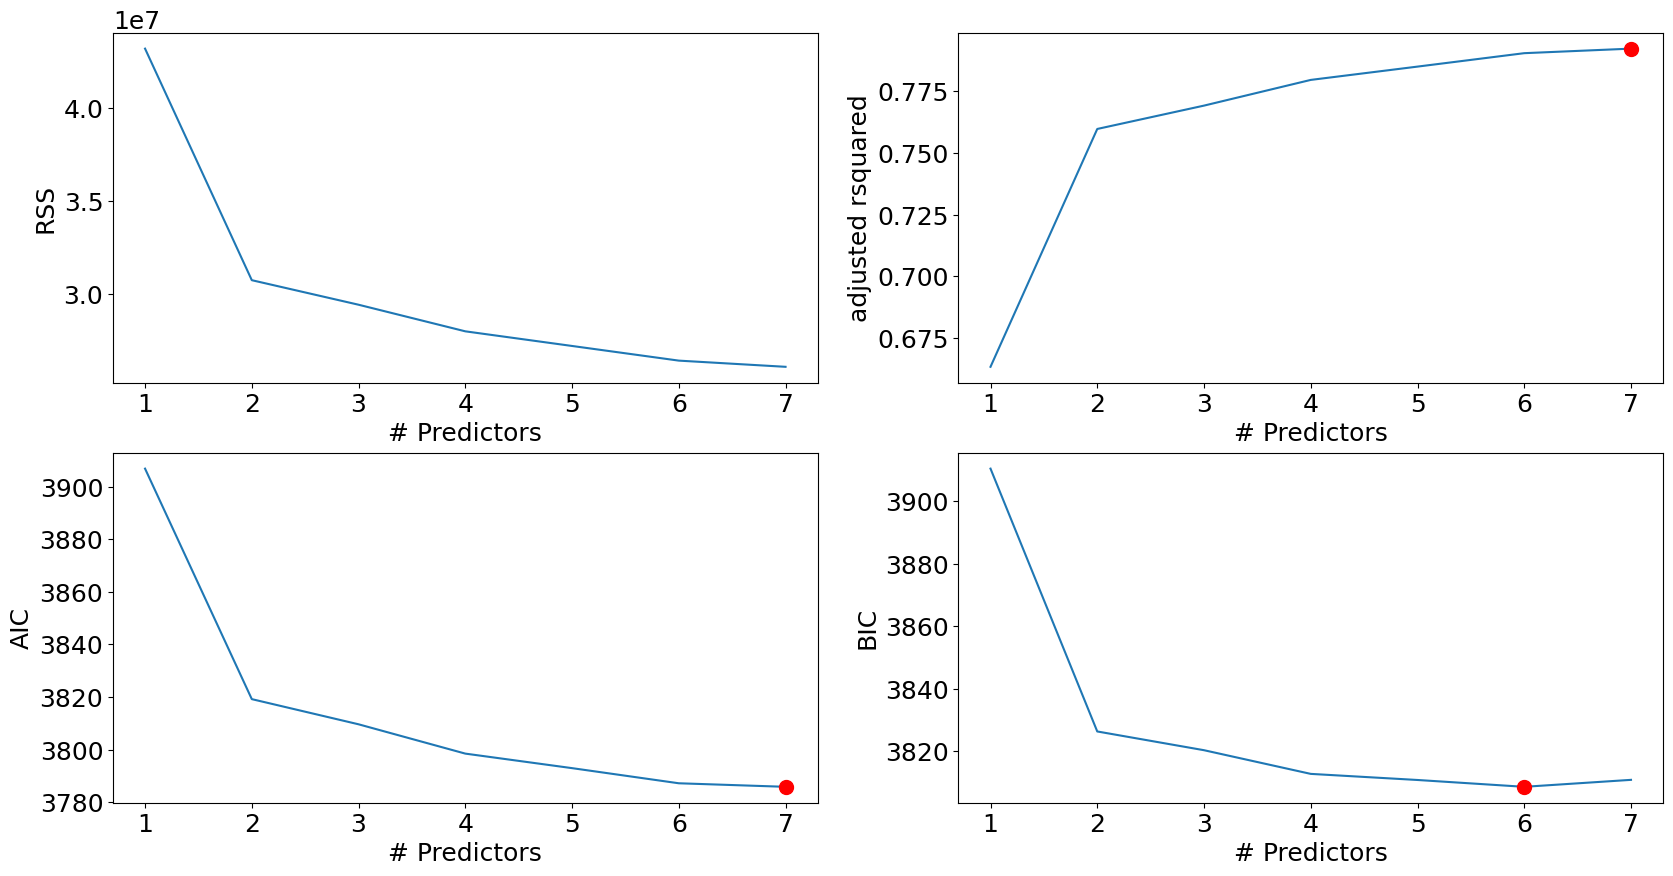

In [29]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any  𝑘<=𝑝
  predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted  𝑅2
  something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

**Example: Forward Selection**

In [30]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]

    tic = time.time()

    results = []

    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]

    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")

    # Return the best model, along with some other useful information about the model
    return best_model

In [31]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.1505424976348877 seconds.
Processed  18 models on 2 predictors in 0.10416102409362793 seconds.
Processed  17 models on 3 predictors in 0.19945168495178223 seconds.
Processed  16 models on 4 predictors in 0.1510329246520996 seconds.
Processed  15 models on 5 predictors in 0.3355998992919922 seconds.
Processed  14 models on 6 predictors in 0.29537272453308105 seconds.
Processed  13 models on 7 predictors in 0.2293252944946289 seconds.
Processed  12 models on 8 predictors in 0.30617666244506836 seconds.
Processed  11 models on 9 predictors in 0.2505040168762207 seconds.
Processed  10 models on 10 predictors in 0.24794840812683105 seconds.
Processed  9 models on 11 predictors in 0.13663291931152344 seconds.
Processed  8 models on 12 predictors in 0.06752562522888184 seconds.
Processed  7 models on 13 predictors in 0.0417630672454834 seconds.
Processed  6 models on 14 predictors in 0.03711509704589844 seconds.
Processed  5 models on 15 predictors in

In [32]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.665
Model:                            OLS   Adj. R-squared (uncentered):              0.663
Method:                 Least Squares   F-statistic:                              519.2
Date:                Wed, 08 May 2024   Prob (F-statistic):                    4.20e-64
Time:                        03:20:11   Log-Likelihood:                         -1952.4
No. Observations:                 263   AIC:                                      3907.
Df Residuals:                     262   BIC:                                      3910.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We see that using forward stepwise selection, the best one-variable model contains only Hits, and the best two-variable model additionally includes CRBI. Let's see how the models stack up against best subset selection:

In [33]:
print(models_best.loc[6, "model"].summary())
print(models_fwd.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              166.3
Date:                Wed, 08 May 2024   Prob (F-statistic):                    1.79e-85
Time:                        03:22:00   Log-Likelihood:                         -1887.6
No. Observations:                 263   AIC:                                      3787.
Df Residuals:                     257   BIC:                                      3809.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Example: Backward Selection**

In [34]:
def backward(predictors):

    tic = time.time()

    results = []

    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]

    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")

    # Return the best model, along with some other useful information about the model
    return best_model

In [35]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time", (toc-tic), "seconds.")

Processed  19 models on 18 predictors in 0.15756916999816895 seconds.
Processed  18 models on 17 predictors in 0.12609314918518066 seconds.
Processed  17 models on 16 predictors in 0.12844634056091309 seconds.
Processed  16 models on 15 predictors in 0.10718083381652832 seconds.
Processed  15 models on 14 predictors in 0.0967719554901123 seconds.
Processed  14 models on 13 predictors in 0.12152552604675293 seconds.
Processed  13 models on 12 predictors in 0.11027765274047852 seconds.
Processed  12 models on 11 predictors in 0.04709935188293457 seconds.
Processed  11 models on 10 predictors in 0.041748762130737305 seconds.
Processed  10 models on 9 predictors in 0.03847932815551758 seconds.
Processed  9 models on 8 predictors in 0.04326462745666504 seconds.
Processed  8 models on 7 predictors in 0.03751873970031738 seconds.
Processed  7 models on 6 predictors in 0.024170875549316406 seconds.
Processed  6 models on 5 predictors in 0.023385047912597656 seconds.
Processed  5 models on 4 pr

In [36]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)

------------
Best Subset:
------------
Hits            1.680029
Walks           3.399961
CAtBat         -0.328835
CHits           1.347017
CHmRun          1.349373
PutOuts         0.248166
Division_W   -111.943760
dtype: float64


Best Subset Selection
In the Best Subset Selection output, the coefficients indicate:

Hits (1.680029): Each additional hit is associated with an increase in salary of approximately $1,680, assuming all other factors are constant.

Walks (3.399961): Each additional walk is associated with an increase in salary of approximately $3,400.

CAtBat (-0.328835): Each additional career at-bat is associated with a decrease in salary of approximately $329. This might indicate that players with long careers but less impressive stats per at-bat might earn less.

CHits (1.347017): Each additional career hit increases the salary by approximately $1,347.

CHmRun (1.349373): Each additional career home run increases the salary by approximately $1,349.

PutOuts (0.248166): Each additional putout increases the salary by approximately $248. This might indicate the value of defensive plays.

Division_W (-111.943760): Being in the "W" division (possibly Western Division) is associated with a decrease in salary of approximately $111,944 compared to other divisions, which might reflect market or economic differences across divisions.

In [37]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)

-----------------
Foward Selection:
-----------------
Hits            7.277149
CRBI            0.652415
Division_W   -110.656338
PutOuts         0.259787
AtBat          -1.644651
Walks           3.684324
League_N       49.978410
dtype: float64


Hits (7.277149): Each additional hit increases the salary by approximately $7,277, which is a much higher estimate compared to the Best Subset Selection.

CRBI (0.652415): Each additional career RBI increases the salary by approximately $653.

Division_W (-110.656338): Similar to Best Subset, being in the "W" division reduces the salary by approximately $110,656.

PutOuts (0.259787): Slightly higher than in Best Subset, each additional putout increases the salary by approximately $260.

AtBat (-1.644651): Each additional at-bat is associated with a decrease in salary of approximately $1,645.

Walks (3.684324): Each additional walk increases the salary by approximately $3,684.

League_N (49.978410): Being in the "N" league increases the salary by approximately $49,978, indicating significant league-based economic differences.

In [38]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)

-------------------
Backward Selection:
-------------------
AtBat         -1.601655
Hits           6.148449
Walks          5.866033
CRuns          1.097453
CWalks        -0.650614
PutOuts        0.310125
Division_W   -95.027171
dtype: float64


AtBat (-1.601655): Each additional at-bat decreases the salary by approximately $1,602.

Hits (6.148449): Each additional hit increases the salary by approximately $6,148.

Walks (5.866033): Each additional walk increases the salary by approximately $5,866.

CRuns (1.097453): Each additional career run increases the salary by approximately $1,097.

CWalks (-0.650614): Each additional career walk decreases the salary by approximately $651, which might suggest a nuanced interpretation when viewed in the context of other career stats.

PutOuts (0.310125): Each additional putout increases the salary by approximately $310.

Division_W (-95.027171): Being in the "W" division reduces the salary by approximately $95,027, consistent with other models but with a slightly smaller impact.

**Choosing the Best Method**


*   Dataset Size and Predictor Count: If you have a very large number of predictors, Forward or Backward Selection might be more practical than Best Subset. For smaller sets of predictors, Best Subset can be feasible and optimal.

*   Interpretability vs. Predictive Power: If interpretability is more critical, simpler models from Forward or Backward Selection might be preferred. If the goal is to maximize predictive accuracy, Best Subset might be the best, though at a cost of complexity and potential overfitting.


*   Computational Resources: If computational resources or time are limited, Forward or Backward Selection may be more appropriate.

**Empirical Evaluation**
Cross-Validation: You could also use cross-validation to compare models produced by different methods to see which performs best on unseen data, thereby providing a balance between model complexity and predictive power.